In [1]:
import os
import datetime
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
import quandl
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [97]:
ratio = pd.read_pickle('../data/ratio.pkl')
factor = pd.read_pickle('../data/factor.pkl').shift(1)

In [98]:
factor_chosen = pd.read_pickle('../data/factor_chosen_ic.pkl')

In [100]:
### get the selected factor value df ###
df = ratio.copy()
df.sort_index(level=['date'],ascending=True,inplace=True)
dates = list(factor_chosen.keys())
df = df.loc[dates[0]:]

ratio_new = pd.DataFrame(index=df.index,columns=list(range(1,11)))
for date in dates:
    factor_list = factor_chosen[date]
    ratio_new.loc[date,:] = df.loc[date,factor_list].values
ratio_new = ratio_new.fillna(0)
ratio_new['ret'] = df['ret_0_1']
ratio_new

1           2         3         4          5  \
date       ticker                                                          
2007-05-31 A        19.073826  170.086771  1.412528  0.000000   0.343893   
           AAL     221.006944   62.716339 -2.271646  0.000000  72.028328   
           AAPL     32.902602   81.039175  0.637360  0.000000   0.000000   
           ABT     234.754889   56.768708 -0.473754  0.309965   0.860442   
           ADBE    118.179107   63.923531  2.168600  0.000000   0.000000   
...                       ...         ...       ...       ...        ...   
2024-02-29 XYL      -0.110202   11.327752  3.229471  0.368449   0.998529   
           YUM      -0.056831    7.880538  1.615313  0.201806   0.898564   
           ZBH      -0.042009    2.681000  1.229074  0.210245   0.617166   
           ZBRA     -0.083603   27.201000  4.975036  0.133969   0.819683   
           ZTS      -0.036390    7.437435  0.281594  0.179511   1.000000   

                          6          7         8             9          10  \
date       ticker                                                            
2007-05-31 A      -0.094154   2.732500  0.846442 -1.694643e+05    1.247253   
           AAL     0.104804   0.874400  0.864865 -3.703905e+04    0.611345   
           AAPL   -0.182395   2.922300  1.000000  3.390628e+06    0.780933   
           ABT     0.008527   0.934900  0.142061  2.594207e+06    0.736090   
           ADBE   -0.024198   4.358300  1.000000  7.300301e+06    0.983012   
...                     ...        ...       ...           ...         ...   
2024-02-29 XYL     0.616667  47.629858  0.764982  1.122216e-01  121.876255   
           YUM     0.600000  47.254470  0.829037  9.557576e-02  132.817239   
           ZBH     0.533333  31.423623  0.307566  5.843600e-02  126.705950   
           ZBRA    0.500000  13.738045  4.742690  1.705425e-01  262.738700   
           ZTS     0.633333  21.532680  1.012122  8.075959e-02  193.722500   

                        ret  
date       ticker            
2007-05-31 A      -0.094154  
           AAL     0.104804  
           AAPL   -0.182395  
           ABT     0.008527  
           ADBE   -0.024198  
...                     ...  
2024-02-29 XYL    -0.110202  
           YUM    -0.056831  
           ZBH    -0.042009  
           ZBRA   -0.083603  
           ZTS    -0.036390  

[72723 rows x 11 columns]

In [151]:
def analyze_predict_result(predicted_returns): 
    ### analyze predict result ###
    rank_predicted = predicted_returns.reset_index().pivot(index='date',columns='ticker',values='predicted_ret')
    rank_predicted = rank_predicted.apply(lambda x:x.rank(),axis=1).T
    rank_actual = ratio_new[['ret']].reset_index().pivot(index='date',columns='ticker',values='ret')
    rank_actual = rank_actual.apply(lambda x:x.rank(),axis=1).iloc[1:].T

    rank_corr = rank_predicted.corrwith(rank_actual).to_frame()

    sns.set(style="darkgrid")
    plt.figure(figsize=(12, 6))
    plt.plot(rank_corr.index, rank_corr[0], marker='o', linestyle='-', color='b')
    plt.title('Correlation of predicted rank and actual rank', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Correlation', fontsize=12)
    plt.grid(True)
    plt.show()

In [103]:
ratio_new = ratio_new.fillna(0)

In [172]:
def equity_return_prediction(data):
    factor_columns = data.columns[:-1]   
    target_column = 'ret' 
    predicted_returns = pd.DataFrame(index=data.index, columns=['predicted_ret'])

    scaler = StandardScaler()

    unique_dates = data.index.get_level_values('date').unique()
    

    for i in range(1, len(unique_dates)):
        previous_data = data.loc[unique_dates[:i]]

        X_train = previous_data[factor_columns]
        y_train = previous_data[target_column]
        X_train_scaled = scaler.fit_transform(X_train)
        if i < 13: 
            model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        current_date = unique_dates[i]
        X_test = data.loc[(current_date,)][factor_columns]
        X_test_scaled = scaler.transform(X_test)  
        y_pred = model.predict(X_test_scaled)
        predicted_returns.loc[(current_date,), 'predicted_ret'] = y_pred
        
    return predicted_returns.dropna()  
predicted_returns = equity_return_prediction(ratio_new)


In [209]:
predicted_returns.to_pickle("equity_prediction_basic.pkl")

In [153]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [170]:
def calculate_performance_metrics(actuals, predictions):
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    directional_accuracy = np.mean(np.sign(actuals) == np.sign(predictions))
    
    return mse, mae, directional_accuracy


actual_returns = ratio_new['ret']
predicted_re = predicted_returns['predicted_ret']

aligned_actuals = actual_returns[actual_returns.index.isin(predicted_re.index)]
aligned_predictions = predicted_re[predicted_re.index.isin(actual_returns.index)]

mse, mae, directional_accuracy = calculate_performance_metrics(aligned_actuals.values, aligned_predictions.values)

In [171]:
directional_accuracy

0.5435509268211829

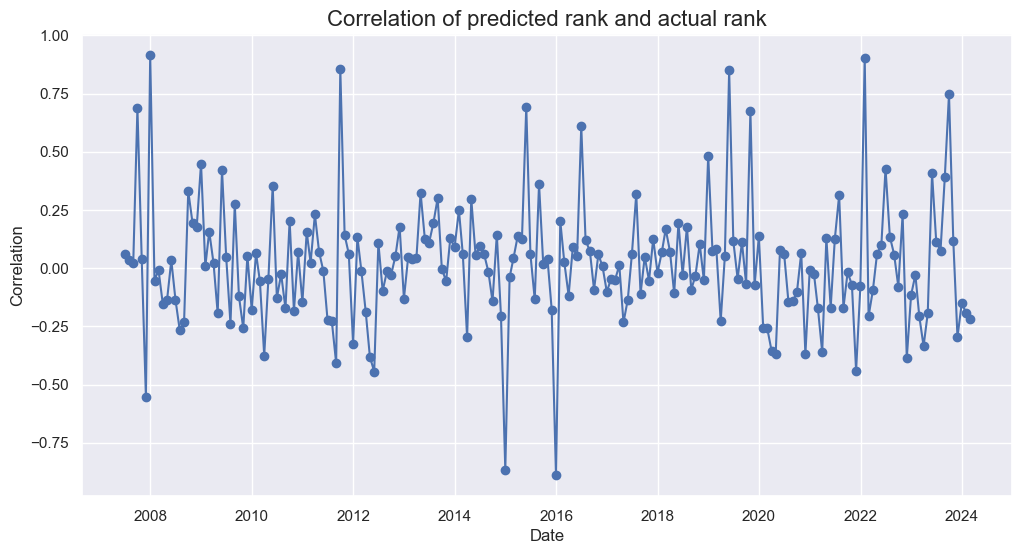

In [152]:
analyze_predict_result(predicted_returns)

# i.r part 

In [174]:
rate = pd.read_pickle('../data/rate.pkl')

In [177]:
rate = rate.to_frame()

In [179]:
rate = rate/ 12

In [187]:
rate_reindexed = rate.reindex(dates)

In [188]:
rate_reindexed

,rate
Date,
2007-05-31,0.398333
2007-06-30,NaN
2007-07-31,0.427500
2007-08-31,0.335833
2007-09-30,NaN
...,...
2023-10-31,0.450000
2023-11-30,0.450000
2023-12-31,NaN


In [189]:
rate_edited = rate_reindexed.fillna(method='ffill')

In [190]:
rate_edited

,rate
Date,
2007-05-31,0.398333
2007-06-30,0.398333
2007-07-31,0.427500
2007-08-31,0.335833
2007-09-30,0.335833
...,...
2023-10-31,0.450000
2023-11-30,0.450000
2023-12-31,0.450000


In [175]:
ratio_new_IR = ratio_new.copy()

In [195]:
rate_edited = rate_edited.rename_axis('date')


In [192]:
ratio_new_IR

1         2         3         4         5         6  \
date       ticker                                                               
2007-05-31 A      -0.001827 -0.013804 -0.007570 -0.011826  0.003708 -0.032421   
           AAL    -0.001754 -0.013818 -0.007571 -0.011826  0.003708 -0.032421   
           AAPL   -0.001822 -0.013816 -0.007570 -0.011826  0.003708 -0.032421   
           ABT    -0.001749 -0.013819 -0.007571 -0.011826  0.003708 -0.032421   
           ADBE   -0.001791 -0.013818 -0.007570 -0.011826  0.003708 -0.032421   
...                     ...       ...       ...       ...       ...       ...   
2024-02-29 XYL    -0.001834 -0.013824 -0.007569 -0.011826  0.003708 -0.032420   
           YUM    -0.001834 -0.013825 -0.007570 -0.011826  0.003708 -0.032420   
           ZBH    -0.001834 -0.013826 -0.007570 -0.011826  0.003708 -0.032420   
           ZBRA   -0.001834 -0.013822 -0.007569 -0.011826  0.003708 -0.032420   
           ZTS    -0.001834 -0.013825 -0.007570 -0.011826  0.003708 -0.032420   

                          7         8         9        10       ret  
date       ticker                                                    
2007-05-31 A      -0.039610 -0.010743 -0.030191 -0.078687 -0.094154  
           AAL    -0.039611 -0.010743 -0.011616 -0.078688  0.104804  
           AAPL   -0.039610 -0.010742  0.469181 -0.078687 -0.182395  
           ABT    -0.039611 -0.010743  0.357467 -0.078688  0.008527  
           ADBE   -0.039610 -0.010742  1.017589 -0.078687 -0.024198  
...                     ...       ...       ...       ...       ...  
2024-02-29 XYL    -0.039594 -0.010743 -0.006421 -0.078606 -0.110202  
           YUM    -0.039594 -0.010743 -0.006421 -0.078599 -0.056831  
           ZBH    -0.039600 -0.010743 -0.006421 -0.078603 -0.042009  
           ZBRA   -0.039606 -0.010741 -0.006421 -0.078512 -0.083603  
           ZTS    -0.039603 -0.010742 -0.006421 -0.078558 -0.036390  

[72723 rows x 11 columns]

In [196]:
merged_df = ratio_new_IR.reset_index().merge(rate_edited.reset_index(), on='date', how='left').set_index(['date', 'ticker'])

In [199]:
merged_df

1         2         3         4         5         6  \
date       ticker                                                               
2007-05-31 A      -0.001827 -0.013804 -0.007570 -0.011826  0.003708 -0.032421   
           AAL    -0.001754 -0.013818 -0.007571 -0.011826  0.003708 -0.032421   
           AAPL   -0.001822 -0.013816 -0.007570 -0.011826  0.003708 -0.032421   
           ABT    -0.001749 -0.013819 -0.007571 -0.011826  0.003708 -0.032421   
           ADBE   -0.001791 -0.013818 -0.007570 -0.011826  0.003708 -0.032421   
...                     ...       ...       ...       ...       ...       ...   
2024-02-29 XYL    -0.001834 -0.013824 -0.007569 -0.011826  0.003708 -0.032420   
           YUM    -0.001834 -0.013825 -0.007570 -0.011826  0.003708 -0.032420   
           ZBH    -0.001834 -0.013826 -0.007570 -0.011826  0.003708 -0.032420   
           ZBRA   -0.001834 -0.013822 -0.007569 -0.011826  0.003708 -0.032420   
           ZTS    -0.001834 -0.013825 -0.007570 -0.011826  0.003708 -0.032420   

                          7         8         9        10       ret      rate  
date       ticker                                                              
2007-05-31 A      -0.039610 -0.010743 -0.030191 -0.078687 -0.094154  0.398333  
           AAL    -0.039611 -0.010743 -0.011616 -0.078688  0.104804  0.398333  
           AAPL   -0.039610 -0.010742  0.469181 -0.078687 -0.182395  0.398333  
           ABT    -0.039611 -0.010743  0.357467 -0.078688  0.008527  0.398333  
           ADBE   -0.039610 -0.010742  1.017589 -0.078687 -0.024198  0.398333  
...                     ...       ...       ...       ...       ...       ...  
2024-02-29 XYL    -0.039594 -0.010743 -0.006421 -0.078606 -0.110202  0.448333  
           YUM    -0.039594 -0.010743 -0.006421 -0.078599 -0.056831  0.448333  
           ZBH    -0.039600 -0.010743 -0.006421 -0.078603 -0.042009  0.448333  
           ZBRA   -0.039606 -0.010741 -0.006421 -0.078512 -0.083603  0.448333  
           ZTS    -0.039603 -0.010742 -0.006421 -0.078558 -0.036390  0.448333  

[72723 rows x 12 columns]

In [200]:
for c in merged_df.columns[:-2]: 
    merged_df[c] = merged_df[c] * merged_df['rate']

In [201]:
merged_df.drop(columns = ['rate'], inplace = True)

In [203]:
predicted_returns_ir = equity_return_prediction(merged_df)

In [205]:
predicted_returns_ir

predicted_ret
date       ticker              
2007-06-30 A          -0.194218
           AAL        -0.583314
           AAPL        0.484969
           ABT        -0.237291
           ADBE       -0.410758
...                         ...
2024-02-29 XYL        -0.008926
           YUM        -0.008926
           ZBH        -0.008926
           ZBRA       -0.008926
           ZTS        -0.008926

[72398 rows x 1 columns]

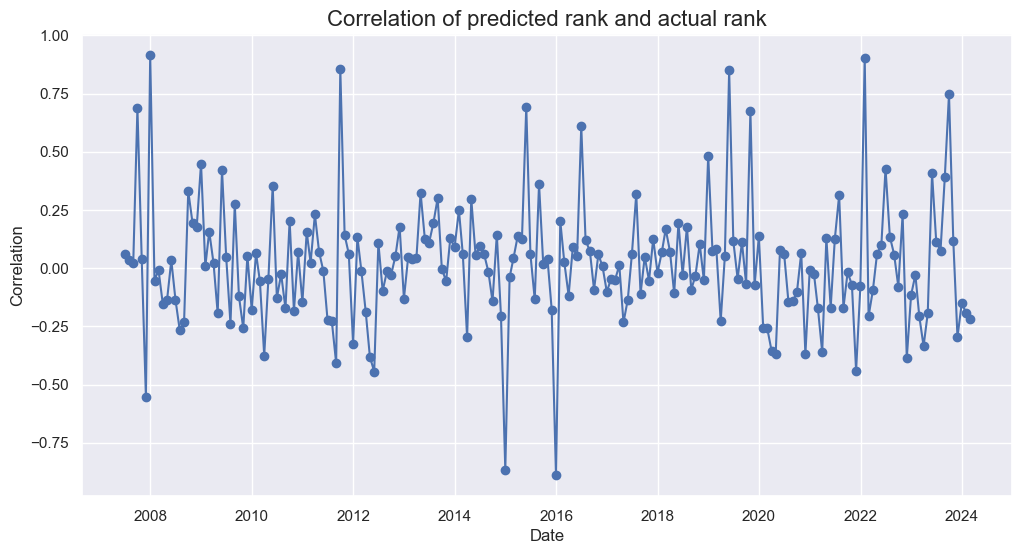

In [204]:
analyze_predict_result(predicted_returns)

In [206]:
actual_returns = ratio_new['ret']
predicted_re = predicted_returns_ir['predicted_ret']

aligned_actuals = actual_returns[actual_returns.index.isin(predicted_re.index)]
aligned_predictions = predicted_re[predicted_re.index.isin(actual_returns.index)]

mse, mae, directional_accuracy = calculate_performance_metrics(aligned_actuals.values, aligned_predictions.values)

In [207]:
directional_accuracy

0.5516312605320589

In [210]:
predicted_returns_ir.to_pickle("predicted_returns_ir_version.pkl")